In [1]:
# importing packages and modules
import numpy as np
import matplotlib as mpl
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from io_utils import *
from utils import *
from plotting_utils import *
from analysis_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm, ttest_rel
sns.set_context("talk")

colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']
colorsStates = ['tab:orange','tab:blue','tab:green','tab:purple', 'tab:brown']
myFeatures = ['stimulus','bias','previous choice','previous correct side']
ibl_data_path = '../data_IBL'
# load dataset with all animals
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

In [2]:
labChosen =  ['angelakilab','churchlandlab','wittenlab']
subjectsAll = []
for lab in labChosen:
    subjects = np.unique(dfAll[dfAll['lab'] == lab]['subject']).tolist()
    subjectsAll = subjectsAll + subjects

# missing data
if ('NYU-01' in subjectsAll):
    subjectsAll.remove('NYU-01')
if ('NYU-06' in subjectsAll):
    subjectsAll.remove('NYU-06')
if ('CSHL_007' in subjectsAll):
    subjectsAll.remove('CSHL_007')
if ('CSHL049' in subjectsAll):
    subjectsAll.remove('CSHL049')

avg_session_length = 995 # from ibl_witten_15

In [3]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 0
priorDirP = [10,1]
maxiter = 300
splitFolds = 5
K = 3
D = 4 # number of features
sessStop = None # last session to use in fitting
pTanh = 5 # tanh transformation
signedStimulus = True # signed stimulus contrast
fit_init_states = False # not fitting initial latent
K_max = 5 # maximum number of states
bestSigmaInd = 8  # Choosing best sigma index across animals
bestAlphaInd = 2  # Choosing best sigma index across animals
pi = np.ones((K)) / K

In [4]:
# load test log-likelihood for 3-state dynamic glm-hmm and Sebastian Bruijns et al (dynamic infinite semi-Markov model)

p_val = []

# animals that were fit with both models
animals_Sebastian = ['CSHL_003','CSHL_004','CSHL_005','CSHL_008','CSHL_010','CSHL_012','CSHL_014','CSHL_015','ibl_witten_06','ibl_witten_12','ibl_witten_13','ibl_witten_14','ibl_witten_15','ibl_witten_16','IBL-T1','IBL-T2','IBL-T3','NYU-02','NYU-04','NYU-07']
# number of sessions to look at 
sessInterest = 30 
testLl_sessions_Lenca = np.ma.empty((len(animals_Sebastian), sessInterest))
testLl_sessions_Lenca.mask = True
testLl_sessions_Sebastian = np.ma.empty((len(animals_Sebastian), sessInterest))
testLl_sessions_Sebastian.mask = True

significant_binary = np.zeros((sessInterest))

idx = 0
for subject in animals_Sebastian:
    data_Sebastian = np.load(f'../data_IBL/sab_results_/sab_results_{subject}.npy')
    sess = data_Sebastian.shape[1]
    stop = min(sessInterest,sess)
    
    # test log likelihood per session from dynamic infinite semi-Markov model
    testLl_sessions_Sebastian[idx,:stop] = data_Sebastian.mean(axis=0)[:stop] # average across folds

    testLL_temp = np.ma.empty((splitFolds), dtype=object)
    for fold in range(0, splitFolds):
        # test log likelihood per session from dynamic GLM-HMM
        data_Lenca = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_3-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        testLL_temp[fold] = data_Lenca['testLlSessions'][bestAlphaInd,0:stop]
    testLl_sessions_Lenca[idx,:stop] =  testLL_temp.mean(axis=0)

    idx += 1

# significance test for comparing the two models
for s in range(sessInterest):
    t, p = ttest_rel(testLl_sessions_Lenca[:,s], testLl_sessions_Sebastian[:,s], nan_policy='omit', alternative='greater')
    p_val.append(np.round(p,3))
    if p < 0.05: # dynamic GLM-HMM performs significantly better than infinite semi-Markov model for this session
        significant_binary[s] = 1
print(p_val)

[np.float64(0.978), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.005), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.001), np.float64(0.003), np.float64(0.013), np.float64(0.001), np.float64(0.167), np.float64(0.024), np.float64(0.42), np.float64(0.086), np.float64(0.016), np.float64(0.014), np.float64(0.016), np.float64(0.037), np.float64(0.056), np.float64(0.005), np.float64(0.141), np.float64(0.018)]


# Supplemental Figure 3A

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


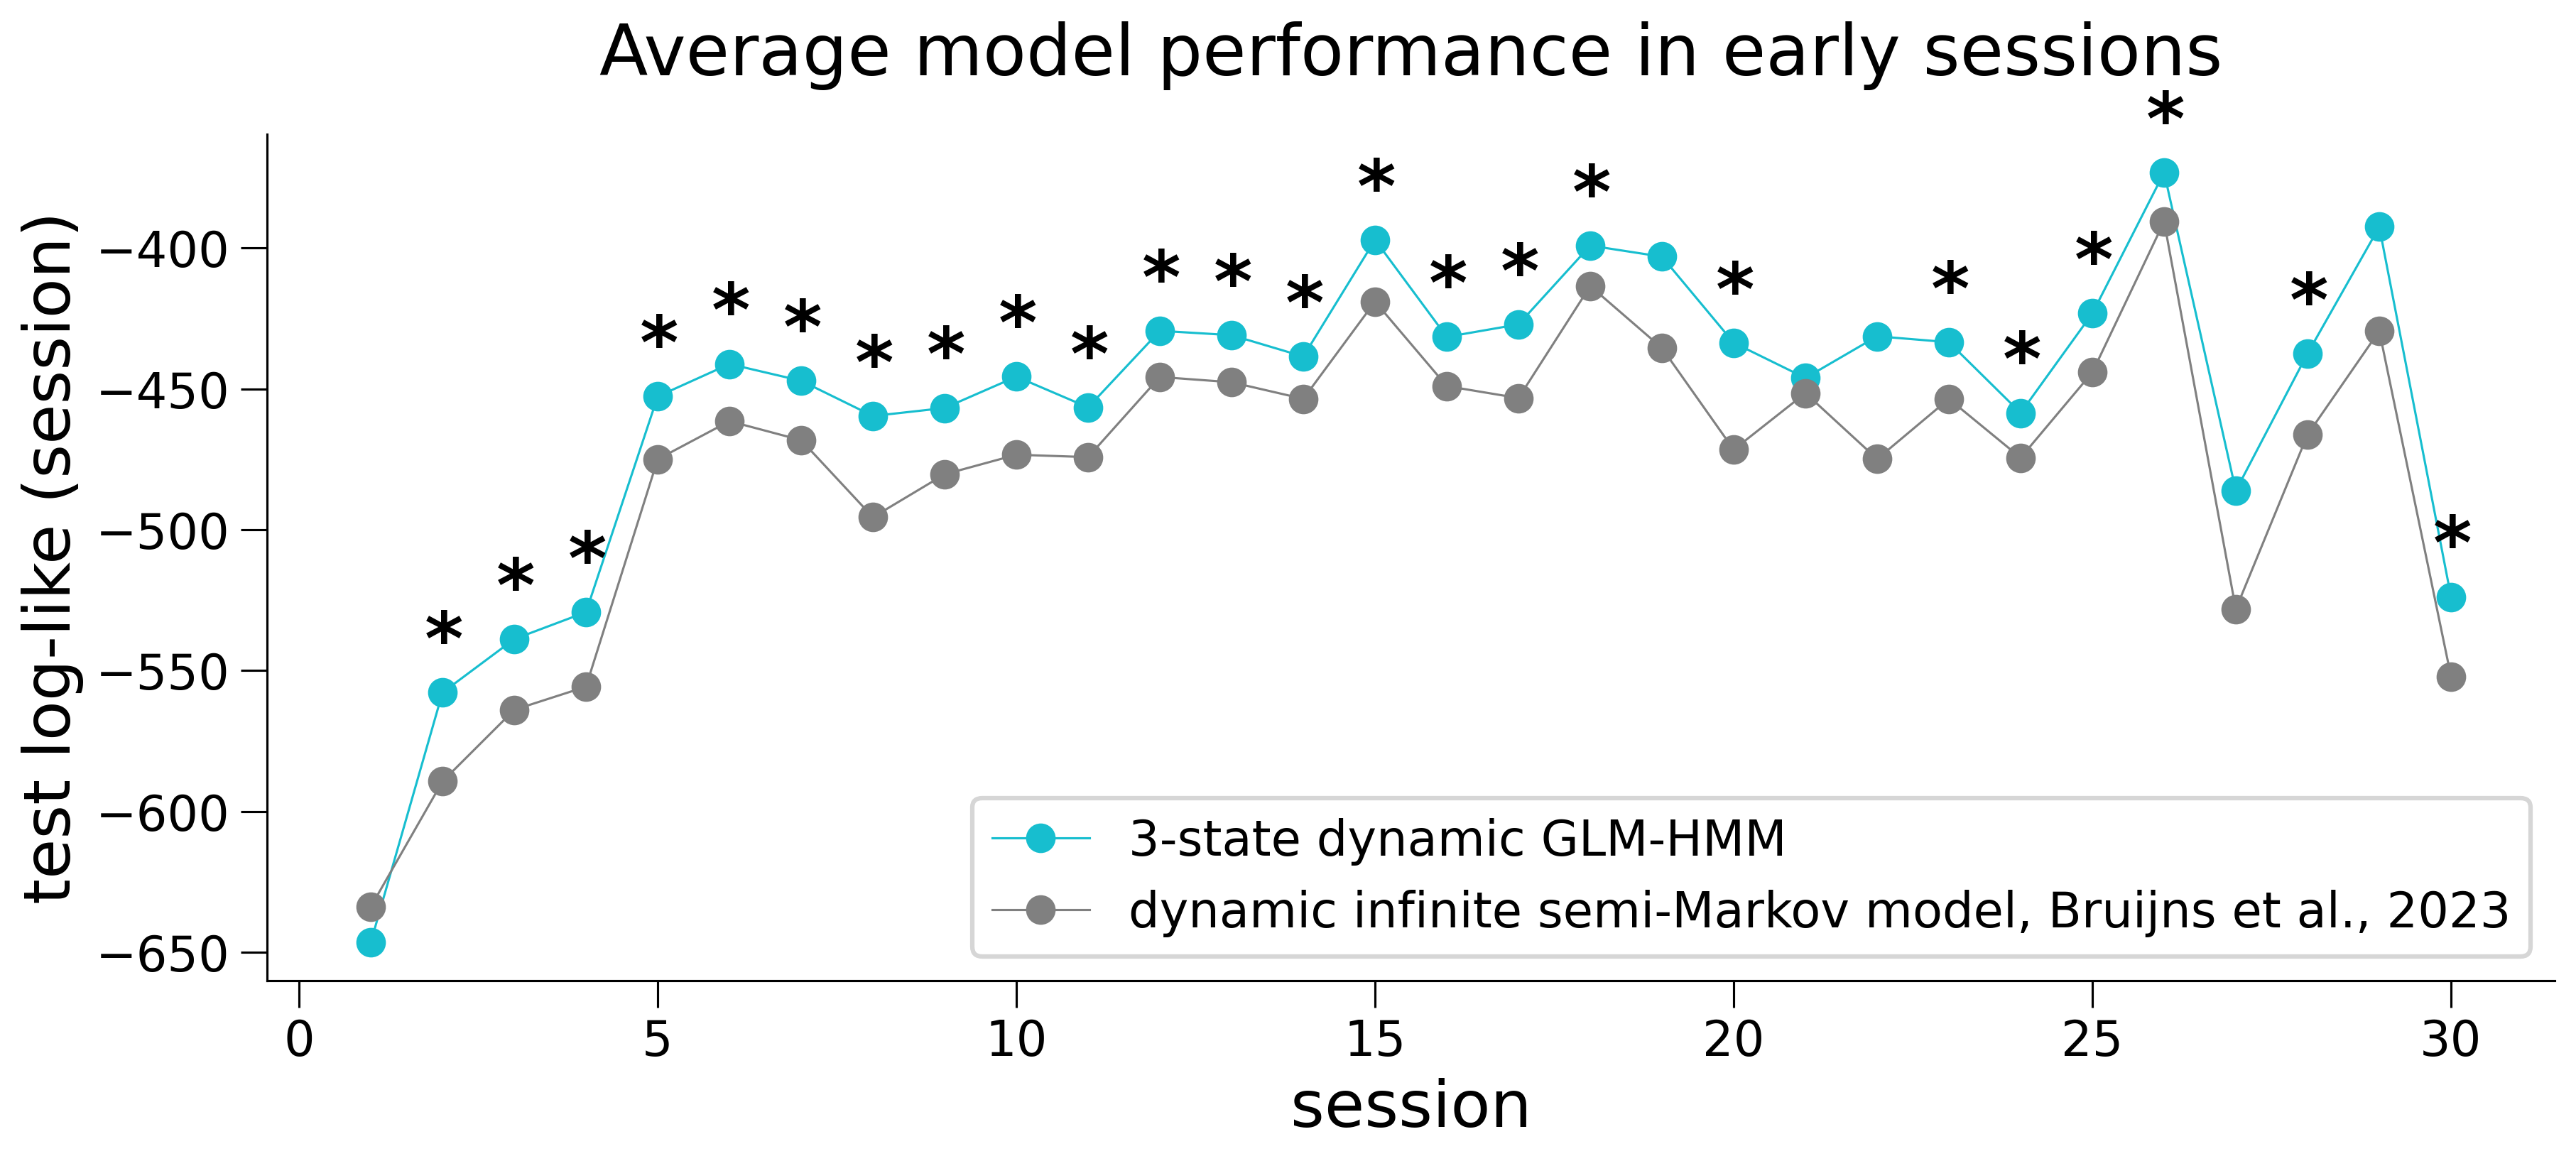

In [5]:
# plot test loglikelihood averaged across animals for the two different models
fig, axes = plt.subplots(1, figsize = (12,5), dpi=300)
fig.tight_layout()
axes.plot(range(1,sessInterest+1), testLl_sessions_Lenca.mean(axis=0) * avg_session_length, '-o', color = colormap[2], linewidth=0.75, label='3-state dynamic GLM-HMM')
axes.plot(range(1,sessInterest+1), testLl_sessions_Sebastian.mean(axis=0) * avg_session_length, '-o', color = 'gray', linewidth=0.75, label='dynamic infinite semi-Markov model, Bruijns et al., 2023')
for s in range(0, sessInterest):
    if significant_binary[s] == 1: # it is significant
        axes.text(s+0.75, testLl_sessions_Lenca.mean(axis=0)[s] * avg_session_length+10, '*', weight='bold', size=25)
axes.set_xlabel('session', size=22)
axes.set_ylabel('test log-like (session)', size=22)
axes.set_title('Average model performance in early sessions', size=24, pad=20)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.set_xticks(range(0,31,5),range(0,31,5))
axes.legend(loc='lower right')
plt.savefig(f'../figures/Test_Log-Like_model_comparison_Bruijns_SuppFig2A.eps', format='eps', bbox_inches='tight', dpi=300)

In [6]:
# computing test log-likelihood for control weights - same as best dynamic weights, except that there is no learning in biased states (states 2 and 3)
testLlAll = np.zeros((len(subjectsAll), splitFolds))
testLlAll_control = np.zeros((len(subjectsAll), splitFolds))

for idx in range(0, len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, signedStimulus=signedStimulus, pTanh=pTanh)
    N = x.shape[0]
    presentTrain, presentTest = split_data(N, sessInd, folds=splitFolds, blocks=10, random_state=1)

    dGLM_HMM = dynamic_glmhmm.dynamic_GLMHMM(N,K,D,2)
    for fold in range(splitFolds):
        data_dynamic = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_{K}-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        testLlAll[idx, fold] = data_dynamic['testLl'][bestAlphaInd]

        #reshape dynamic weights
        allW_best_dynamic, allP_best_dynamic = reshape_parameters_session_to_trials(data_dynamic['allW'][bestAlphaInd], data_dynamic['allP'][bestAlphaInd], sessInd)

        # control weights - no learning in biased states (states 2 and 3)
        allW_best_control = np.array(allW_best_dynamic, copy=True)
        allW_best_control[:, 1, 1, 1] = np.mean(allW_best_control[:, 1, 1, 1]) # state 2 stimulus weights
        allW_best_control[:, 2, 1, 1] = np.mean(allW_best_control[:, 2, 1, 1]) # state 3 stimulus weights

        # evaluate with control weights 
        _, testLlAll_control[idx, fold], _ = dGLM_HMM.evaluate(x, y, sessInd, presentTest[fold], allP_best_dynamic , pi, allW_best_control)
    
# average across folds
testLlAll = testLlAll.mean(axis=1)
testLlAll_control = testLlAll_control.mean(axis=1)

print(ttest_rel(testLlAll, testLlAll_control, alternative='greater'))

TtestResult(statistic=np.float64(18.180183981233206), pvalue=np.float64(2.1629209111781532e-18), df=np.int64(31))


# Supplemental Figure 3B

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


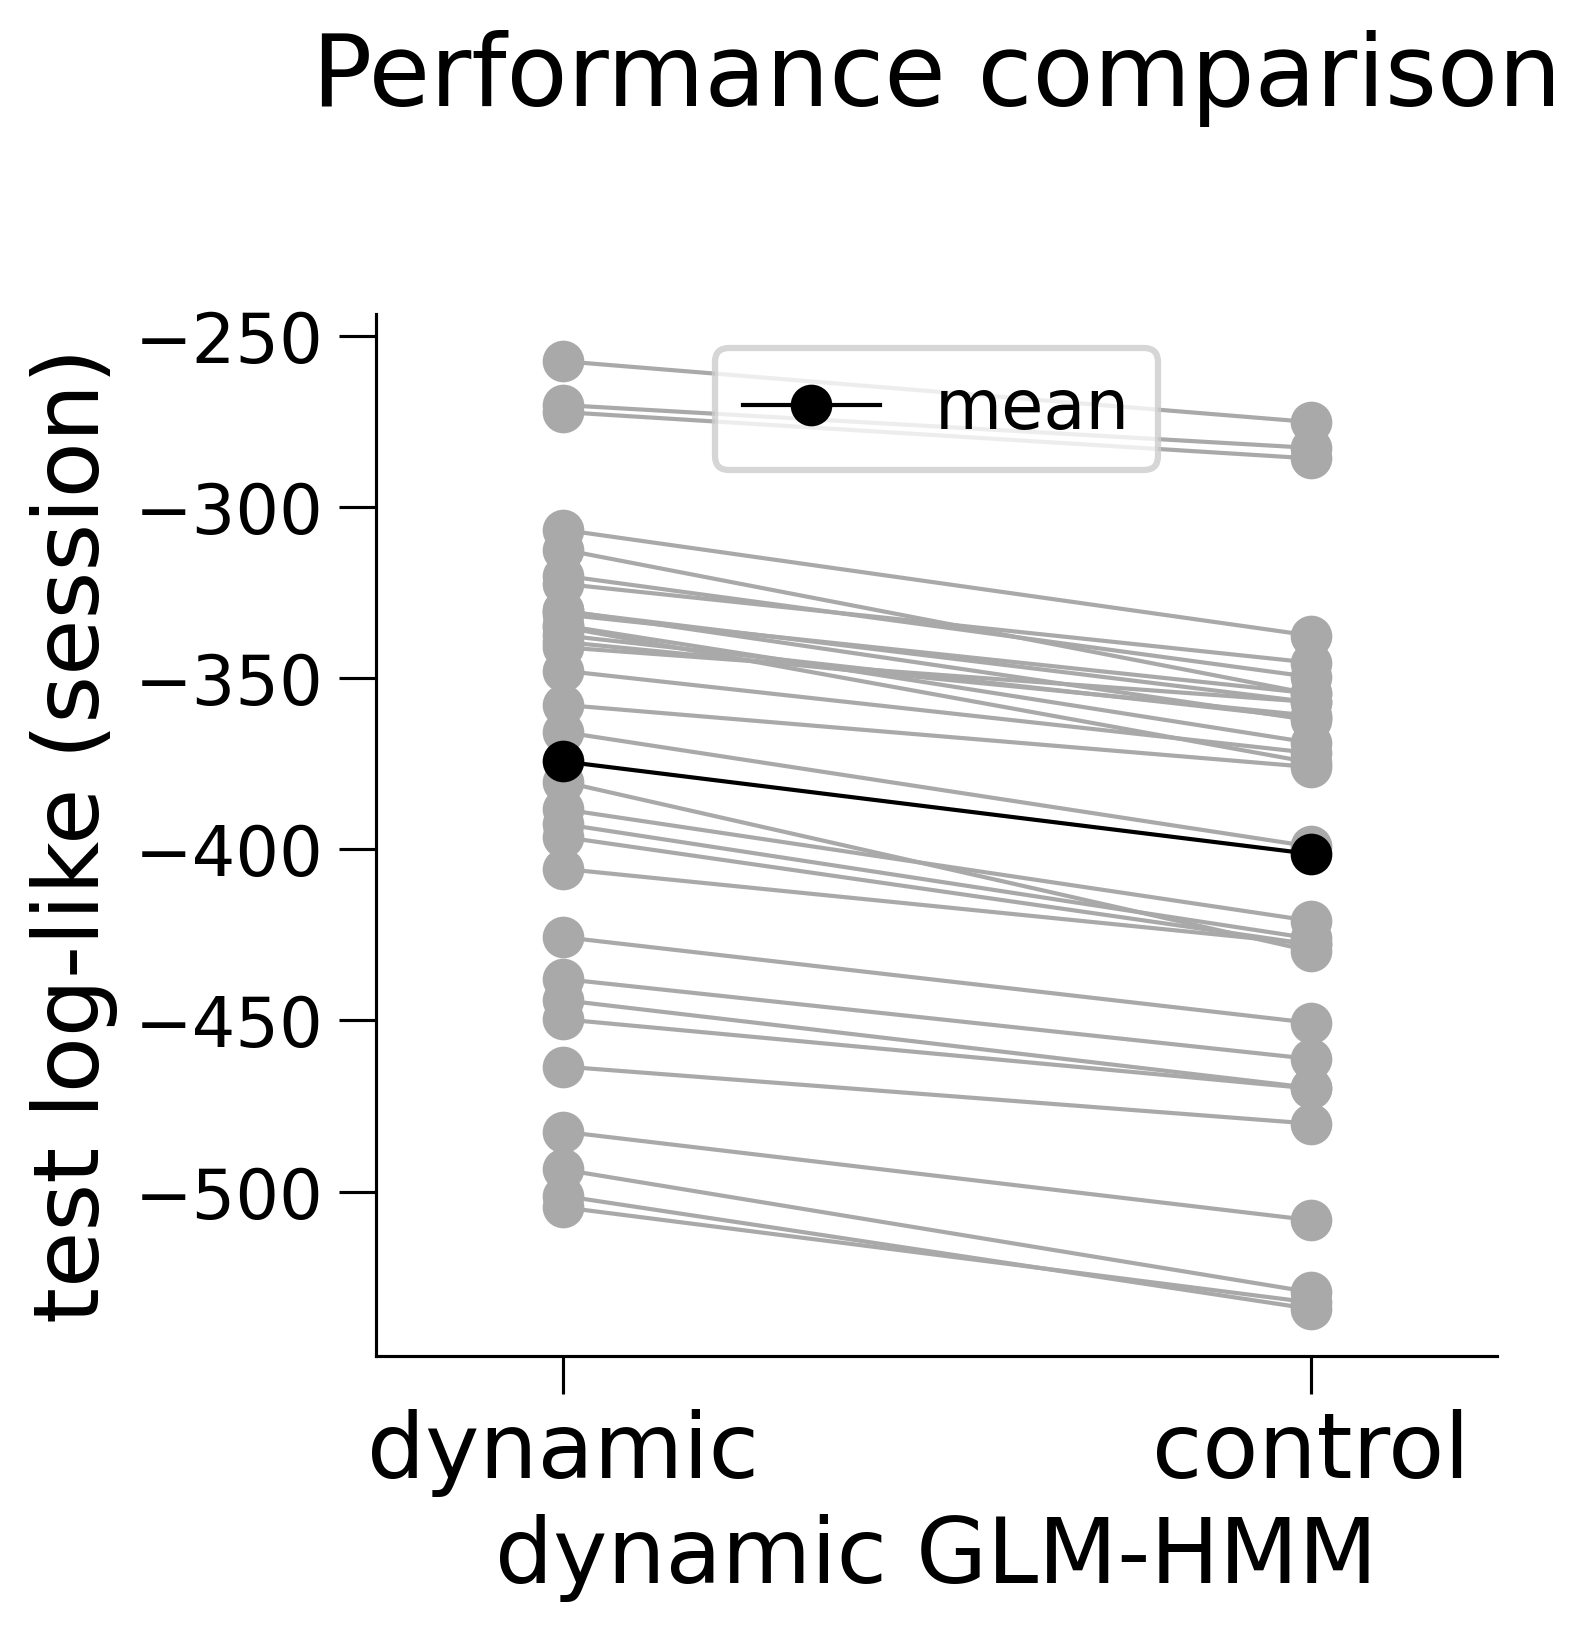

In [7]:
fig, axes = plt.subplots(1, figsize = (5,4.5), dpi=300)
fig.tight_layout()
for idx in range(len(subjectsAll)):
    axes.plot([-1,1], [avg_session_length * testLlAll[idx], avg_session_length * testLlAll_control[idx]], '-o', color='darkgray', linewidth=1)
axes.plot([-1,1], [avg_session_length * np.mean(testLlAll, axis=(0)), avg_session_length * np.mean(testLlAll_control, axis=(0))], '-o', color='black', linewidth=1, label='mean')
axes.set_xticks([-1,1],['dynamic','control'], size=22)
axes.set_xlabel('dynamic GLM-HMM', size=22)
axes.set_ylabel('test log-like (session)', size=22)
axes.set_title('Performance comparison', size=24, pad=50)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.set_xlim(-1.5,1.5)
axes.legend()
plt.savefig(f'../figures/Test_Log-Like_model_comparison_control_SuppFig2B.eps', format='eps', bbox_inches='tight', dpi=300)

# Supplemental Figure 3C

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


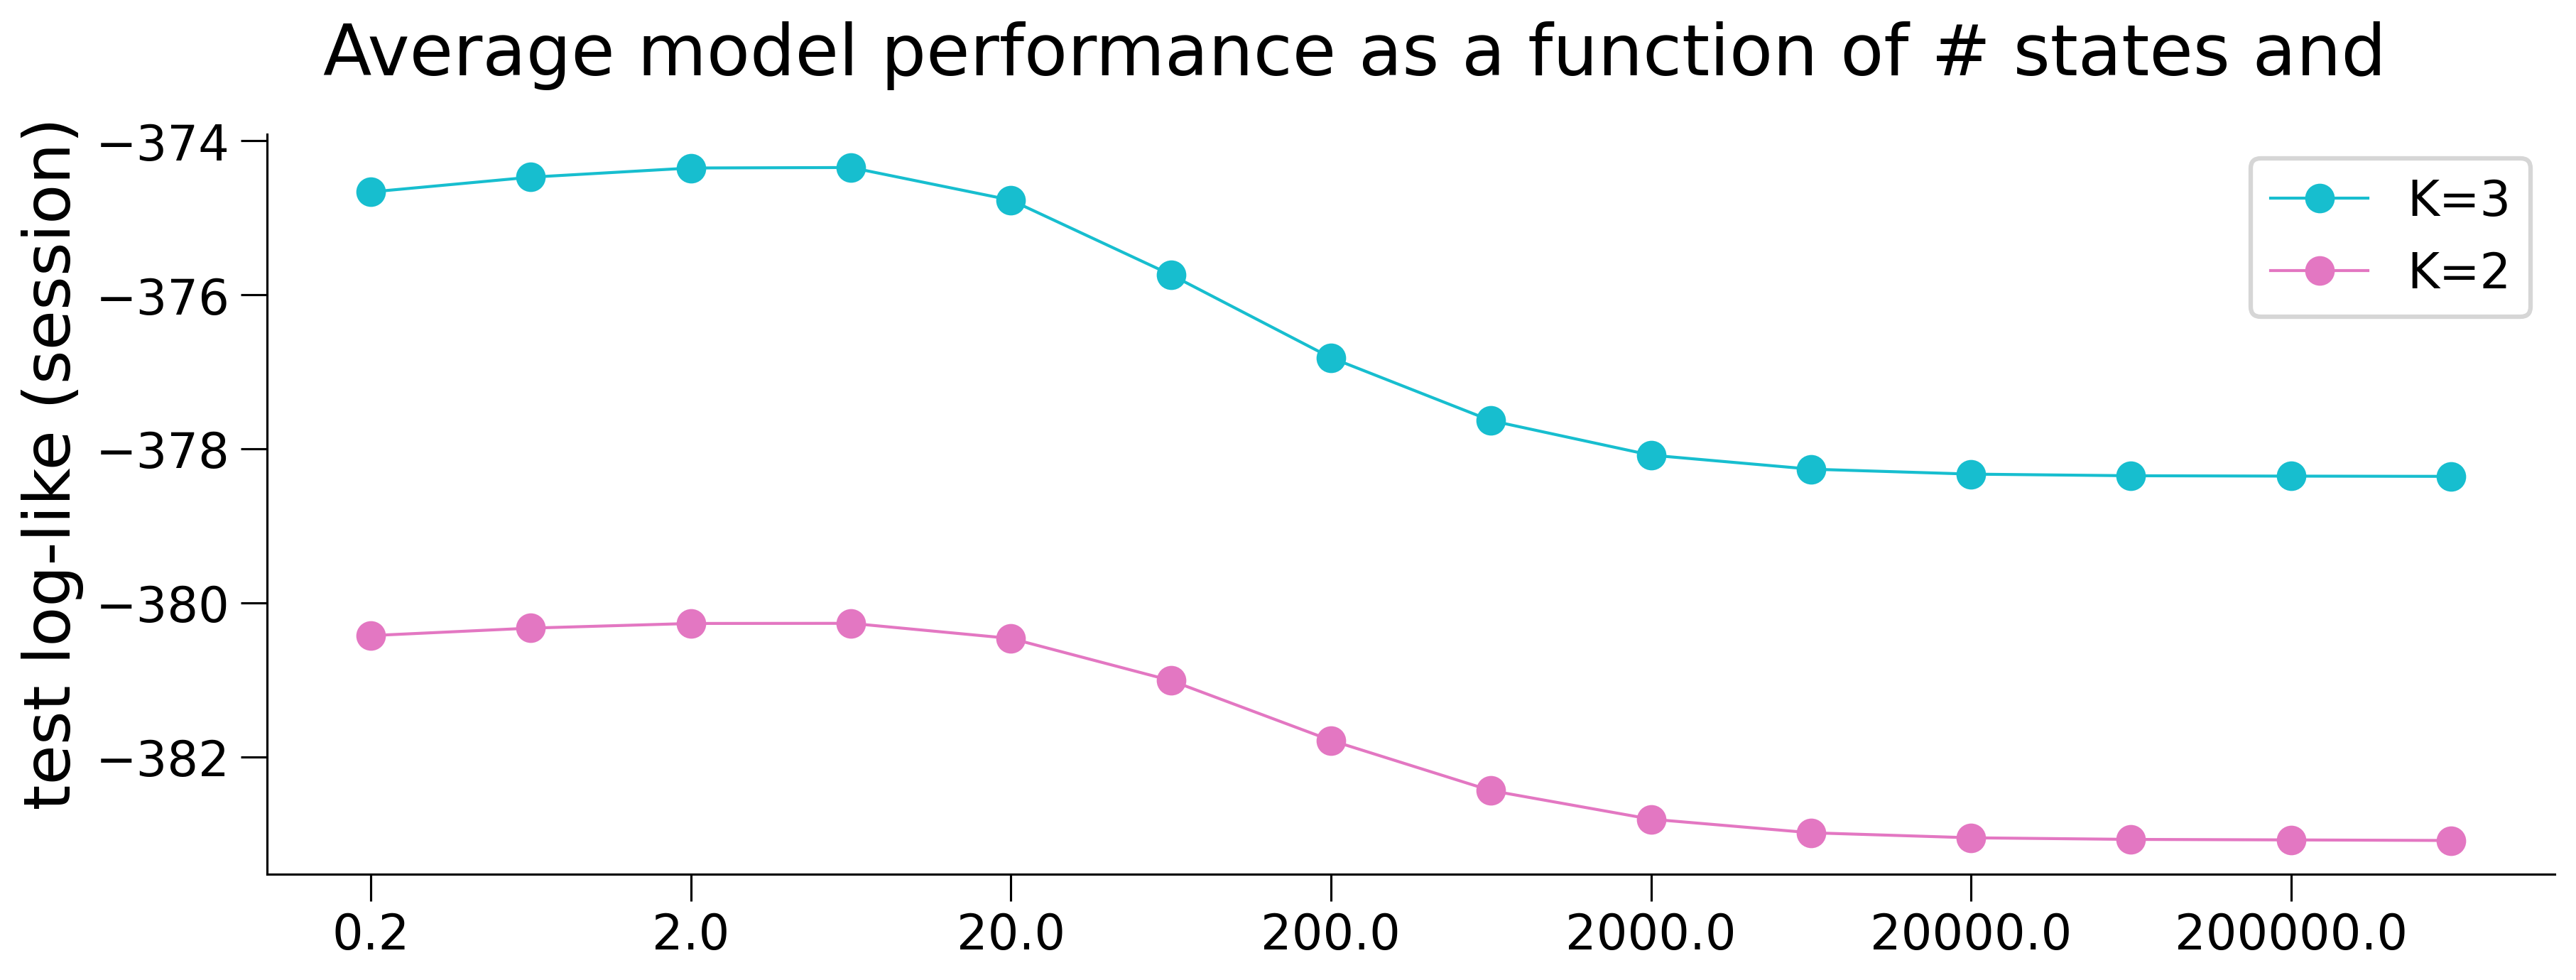

In [8]:
# plotting test log-like as a function of alpha (intensity of Dirichlet prior on transition matrix)
alphaList = [2*(10**x) for x in list(np.arange(-1,6,0.5,dtype=float))]
testLlAll = np.zeros((3, len(subjectsAll), splitFolds, len(alphaList)+1))
for idx in range(0, len(subjectsAll)):
    subject=subjectsAll[idx]
    x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh) # NOT LOOKING AT FULL DATASET
    N = x.shape[0]
    sess = len(sessInd) - 1
    presentTrain, presentTest = split_data(N, sessInd, folds=splitFolds, blocks=10, random_state=1)
    stop = min(sessInterest, sess)
    for fold in range(0, splitFolds):
        data3 = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_3-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        data2 = np.load(f'../data_IBL/{subject}/{subject}_dynamicGLMHMM_CV_2-state_fold={fold}_pTanh={pTanh}_L2penaltyW={L2penaltyW}_signedStimulus={signedStimulus}.npz')
        testLlAll[2,idx,fold] =  data3['testLl'] 
        testLlAll[1,idx,fold] =  data2['testLl'] 
fig, axes = plt.subplots(1, figsize = (12,4.5), dpi=300)
fig.tight_layout()
for k in range(2,0,-1):
    plot_testLl_CV_alpha(testLlAll.mean(axis=(1,2))[k] * avg_session_length, alphaList=alphaList, label=f'K={k+1}', color=colormap[k], axes=axes, alpha=1, linewidth=1)
axes.set_ylabel("    test log-like (session)", size=22)
axes.set_xlabel('')
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
axes.set_title('Average model performance as a function of # states and     ', size=24, pad=20)
plt.savefig(f'../figures/TestLl_vs_states_alpha_all-animals.eps', format='eps', bbox_inches='tight', dpi=300)
  

# Supplemental Figure 3D

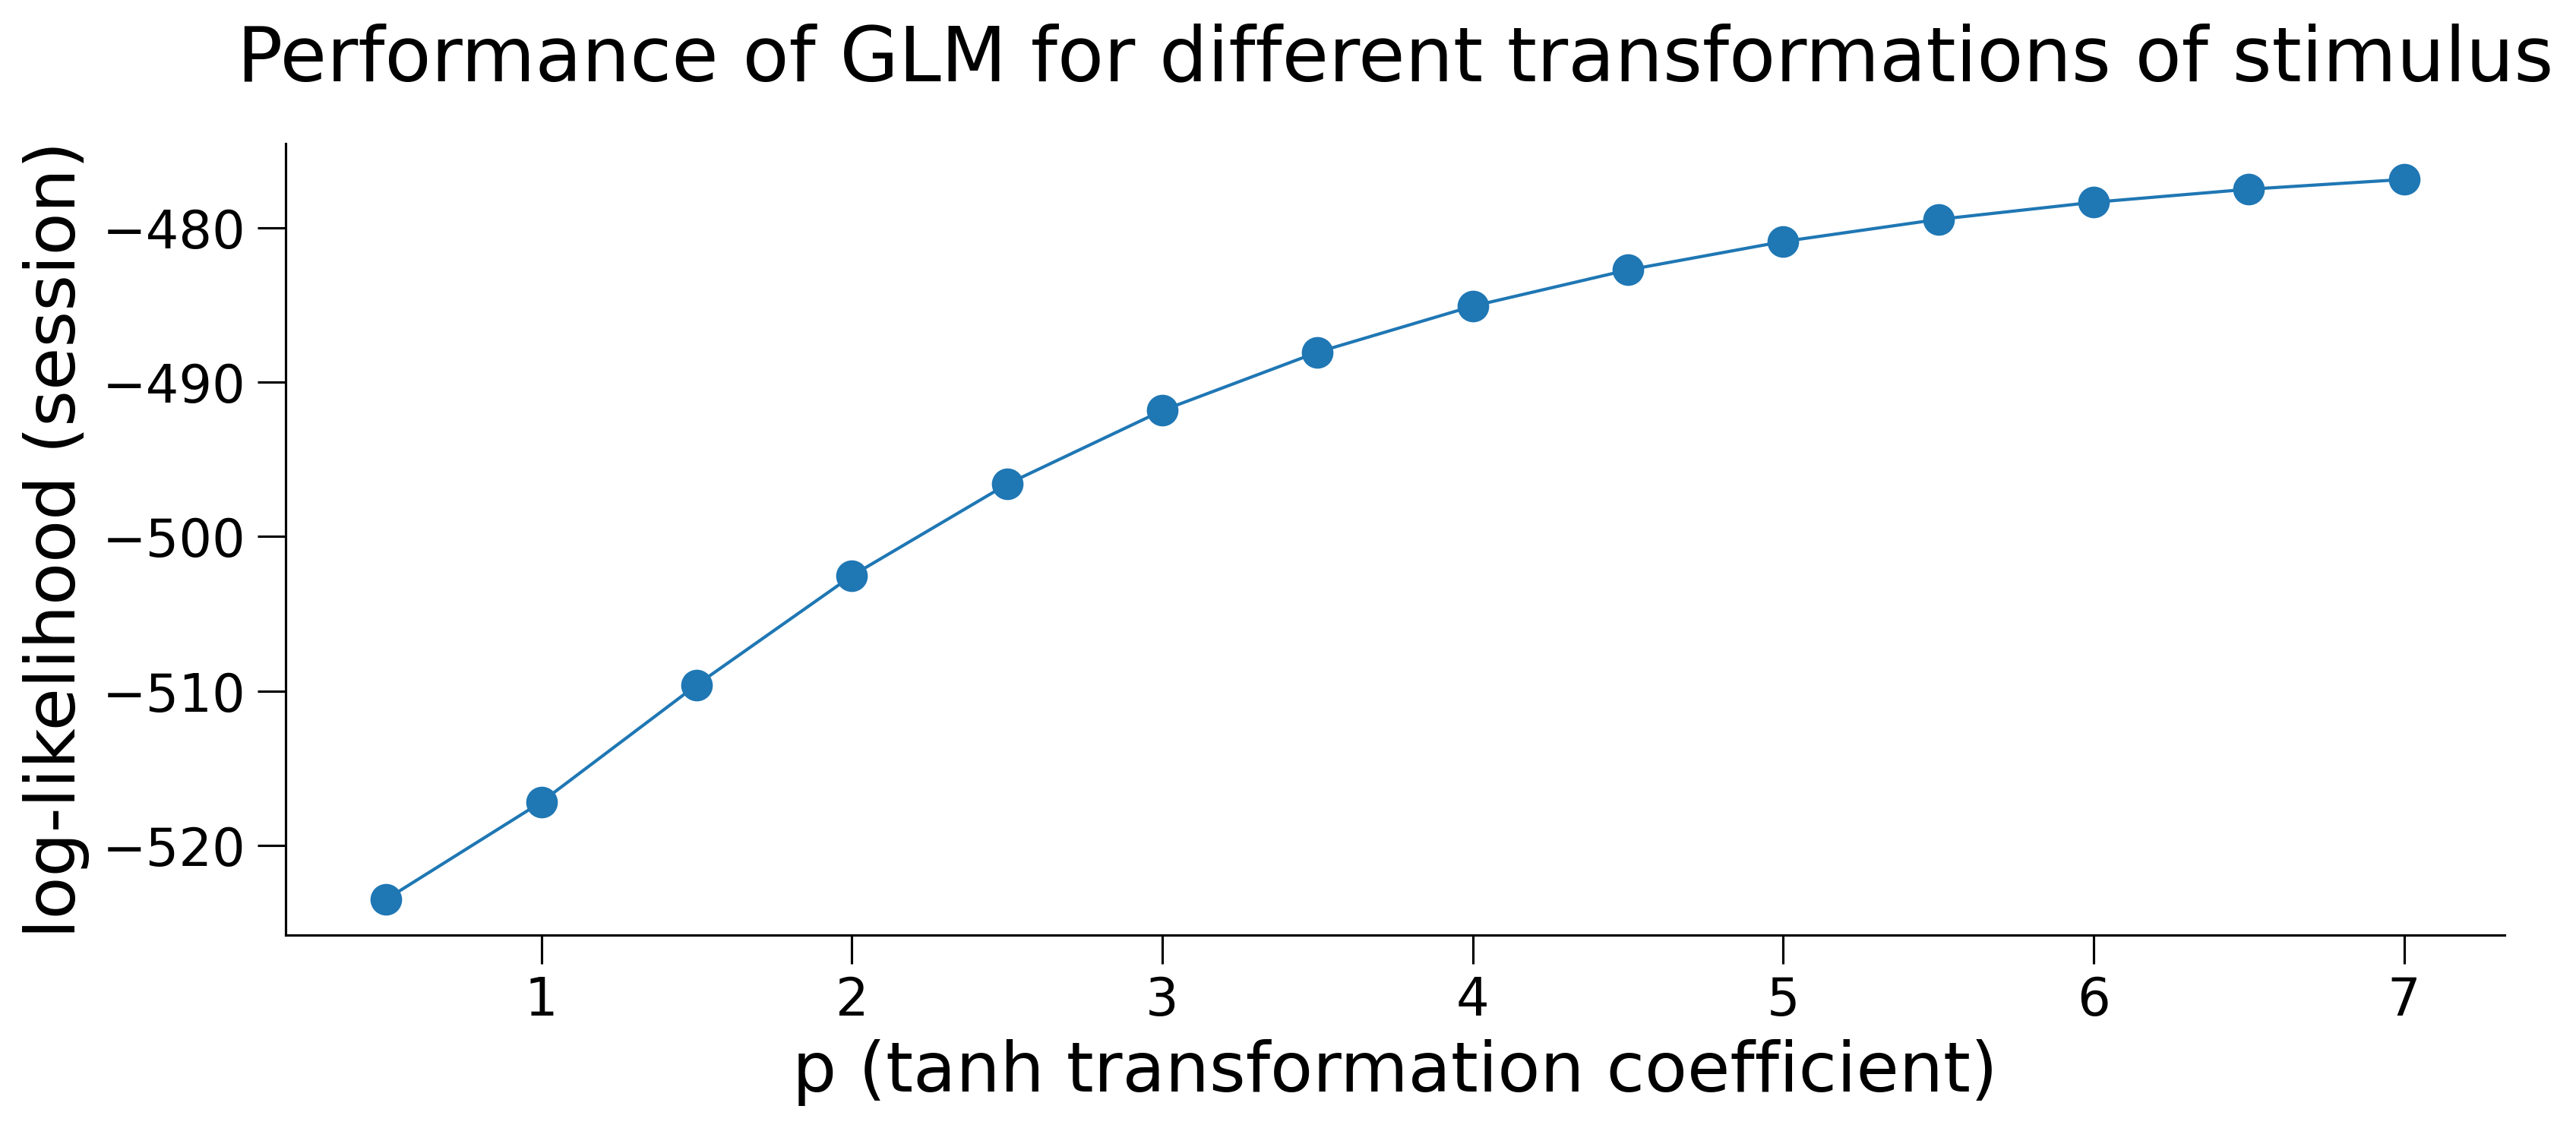

In [9]:
# plot test loglikelihood averaged across animals for the two different models
fig, axes = plt.subplots(1, figsize = (11,4.5), dpi=300)
fig.tight_layout()

pTanh_val = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
Ll = np.zeros((len(pTanh_val)))
for i in range(len(pTanh_val)):
    pTanh = pTanh_val[i]
    Ll[i] = np.load(f'../data_IBL/all_animals/allAnimals_pTanh={pTanh}_GLM_signedStimulus={signedStimulus}.npz')['trainLl']

axes.plot(pTanh_val, Ll * avg_session_length, '-o', linewidth=1)
axes.set_xlabel('p (tanh transformation coefficient)', size=22)
axes.set_ylabel('log-likelihood (session)', size=22)
axes.set_title('Performance of GLM for different transformations of stimulus', size=24, pad=20)
axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom']].set_linewidth(0.75)
axes.xaxis.set_tick_params(width=0.75)
axes.yaxis.set_tick_params(width=0.75)
plt.savefig(f'../figures/GLM_performance_different_tanh_SuppFig2D.eps', format='eps', bbox_inches='tight', dpi=300)